In [2]:
# Standard library imports
import matplotlib.pyplot as plt
from pathlib import Path

# Third-party imports
import nibabel as nib

# MONAI imports
import monai
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    ScaleIntensityRanged,
    CropForegroundd,
    Spacingd,
    Orientationd,
    Resized,
    Invertd,
    ToTensord,
    LabelToContourd,
    LabelFilterd,
    allow_missing_keys_mode
)
from monai.transforms.compose import Compose
from monai.utils import first, set_determinism
from monai.visualize.utils import blend_images, matshow3d
from monai.utils.enums import CommonKeys

2025-05-22 09:49:07.673369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747900147.761307 1026087 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747900147.785737 1026087 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747900147.968646 1026087 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747900147.968701 1026087 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747900147.968703 1026087 computation_placer.cc:177] computation placer alr

In [3]:
print_config()
set_determinism(seed=2345678)

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.7.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/miniconda3/envs/medenv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.3
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 11.2.1
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.22.0+cu126
tqdm version: 4.67.1
lmdb version: 1.6.2
psutil version: 7.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.22.0
pynrrd version: 1.1.3
clearml version: 2.0.0rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [16]:
# Data setup
covid_root_dir = Path("data/")
assert covid_root_dir.exists(), f"Please download the dataset from {covid_root_dir} and unzip it."

# Define paths
raw_images_path = covid_root_dir / "COVID-19-CT-Seg_20cases"
masks_path = covid_root_dir / "Lung_and_Infection_Mask"

# Get file lists
raw_images = sorted(raw_images_path.glob("*.nii.gz"))
masks = sorted(masks_path.glob("*.nii.gz"))
assert len(raw_images) == len(masks), "Number of images and masks do not match."

In [17]:
data = {}
for i, (img, seg) in enumerate(zip(raw_images, masks)):
    data[i] = {
        CommonKeys.IMAGE: str(img),
        CommonKeys.LABEL: str(seg),
    }
print(f"Number of images: {len(data)}")
# Print the first image and mask paths
print(f"First image path: {data[0][CommonKeys.IMAGE]}")
print(f"First mask path: {data[0][CommonKeys.LABEL]}")

Number of images: 20
First image path: data/COVID-19-CT-Seg_20cases/coronacases_001.nii.gz
First mask path: data/Lung_and_Infection_Mask/coronacases_001.nii.gz


In [18]:
# Define common keys to avoid repetition
img_key = CommonKeys.IMAGE
label_key = CommonKeys.LABEL
both_keys = [img_key, label_key]

transform = Compose([
    LoadImaged(keys=both_keys, reader="NibabelReader"),
    EnsureChannelFirstd(keys=both_keys),
    ScaleIntensityRanged(
        keys=[img_key],
        a_min=-1000,
        a_max=400,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    Spacingd(
        keys=both_keys,
        pixdim=(1.5, 1.5, 1.5),
        mode=("bilinear", "nearest"),
    ),
    Orientationd(
         keys=both_keys,
         axcodes=("RAS"), # Axis 0 -> R, Axis 1 -> A, Axis 2 -> S, so 0 are thre rows (Y), 1 are the columns (X), and 2 are the slices (Z)
    ),
    CropForegroundd(
        keys=both_keys,
        source_key=img_key,
        margin=10,
    ),
    LabelFilterd(
        keys=[label_key],
        applied_labels=[0,1,2,3]
    ),
    # LabelToContourd(
    #     keys=["seg"],
    # ),
])

# Create a CacheDataset
train_ds = CacheDataset(
    data=data,
    transform=transform,
    cache_rate=0.05,
)
# Create a DataLoader
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

# Get a batch of data
batch_data = first(train_loader)
# Print the shape of the image and mask tensors
print(f"Image shape: {batch_data[img_key].shape}")
print(f"Mask shape: {batch_data[label_key].shape}")


monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
Loading dataset: 100%|██████████| 1/1 [00:14<00:00, 14.55s/it]


Image shape: torch.Size([1, 1, 288, 288, 177])
Mask shape: torch.Size([1, 1, 288, 288, 177])


In [19]:
blended_imgs = blend_images(
    batch_data[img_key][0],
    batch_data[label_key][0],
    alpha=0.3,
)

## Vistas axiales, coronales y sagitales

En imagenología médica, existen tres planos principales para visualizar estructuras anatómicas:

- **Vista axial (transversal):** Es un corte horizontal que divide el cuerpo en partes superior e inferior. Se observa como si se mirara el cuerpo desde los pies hacia la cabeza.
- **Vista coronal (frontal):** Es un corte vertical que divide el cuerpo en partes anterior (frontal) y posterior (trasera). Se observa como si se mirara el cuerpo de frente.
- **Vista sagital:** Es un corte vertical que divide el cuerpo en partes izquierda y derecha. Si el corte es exactamente en la línea media, se denomina sagital media; si es paralelo a esta, se llama parasagital.

Estas vistas permiten analizar la anatomía y las patologías desde diferentes perspectivas, facilitando el diagnóstico y la planificación de tratamientos.

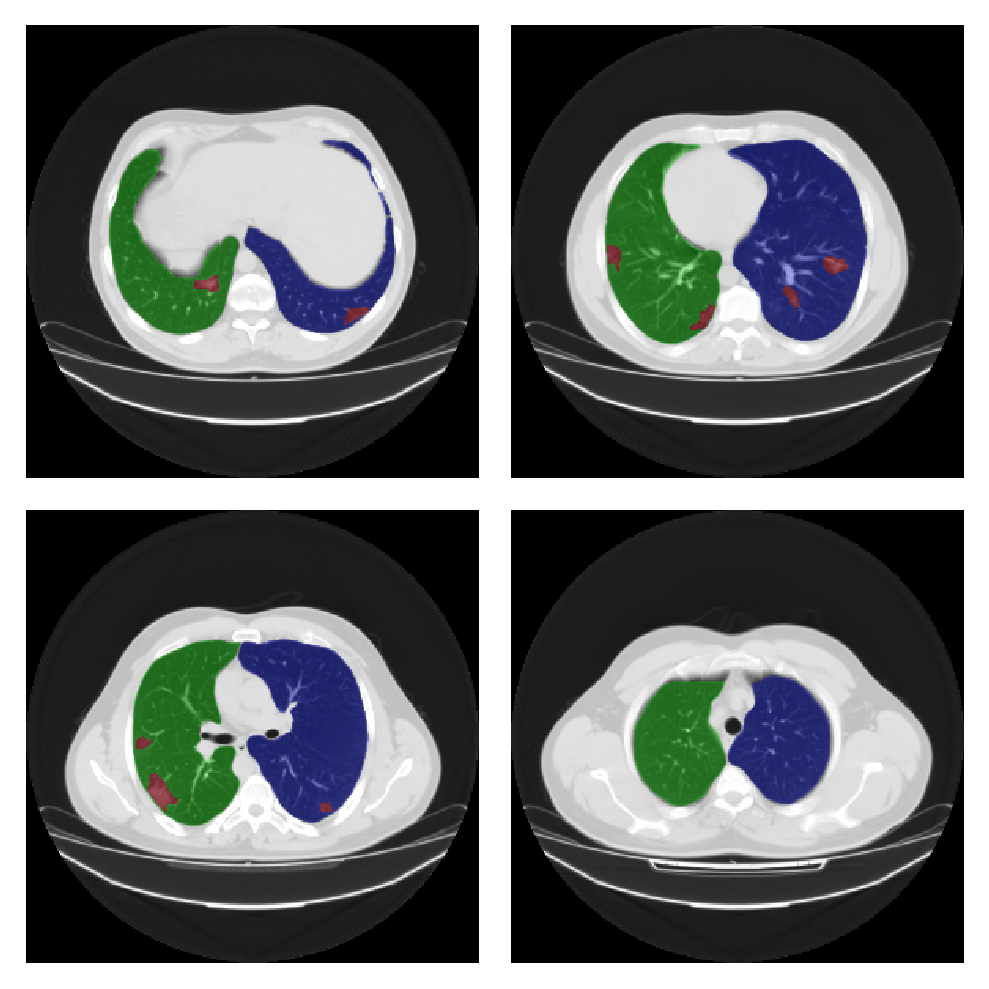

In [20]:
matshow3d(
    blended_imgs.transpose(1,2), # Transpose to match matplotlib's expected input
    channel_dim=0,
    frame_dim=-1,
    margin=10,
    every_n=50,
)
plt.savefig("blended_imgs.png", dpi=500)

### Cortes coronales

Intercambiando los ejes 2 y 3 (`transpose(2,3)`) se obtienen los cortes coronales, que muestran el cuerpo de frente a atrás.

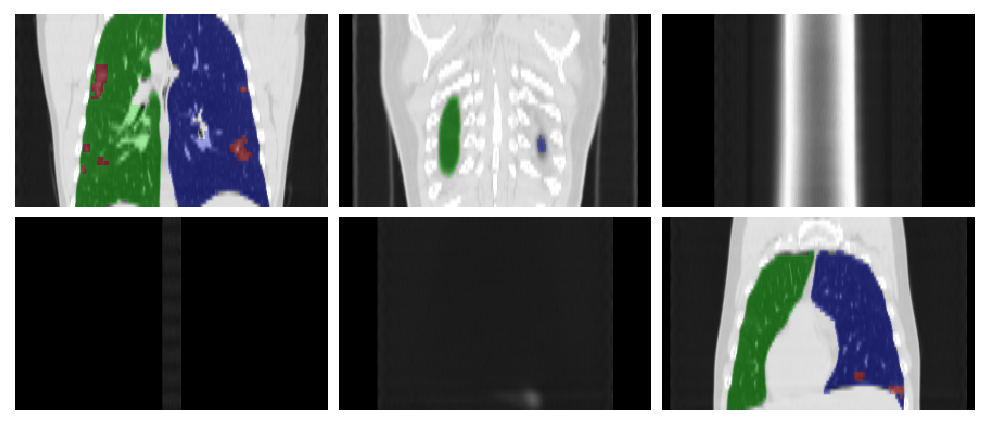

In [21]:
matshow3d(
    blended_imgs.permute(0,3,1,2),  # Intercambia los ejes 2 y 3 para cortes coronales
    channel_dim=0,
    frame_dim=-1,
    margin=5,
    every_n=50,  # Cambia el origen a "lower" para que la imagen se vea correctamente
    origin="lower",
)
plt.savefig("blended_imgs_coronal.png", dpi=500)

In [22]:
import imageio
import numpy as np
import torch

# Ensure blended_imgs is available from a previous cell.
# Expected shape: (C, H, W, D), e.g., (3, H, W, D) after MONAI processing.

# Permute for coronal view. Original W becomes the slicing dimension.
# (C, H, W, D) --> (C, H, D, W)
# Example: (3, 289, 289, 178) --> (3, 289, 178, 289)
coronal_volume = blended_imgs.permute(0, 1, 3, 2).transpose(1,2)
# After permute and transpose, shape is (C, D_orig, H_orig, W_orig)
# Vertical flip is along D_orig (dimension 1)
coronal_volume = torch.flip(coronal_volume, dims=[1])

frames_coronal = []
num_coronal_slices = coronal_volume.shape[3] # Slicing along the new W dimension

for i in range(num_coronal_slices):
    # Get current slice: shape (C, H_slice, D_slice)
    slice_data_coronal = coronal_volume[:, :, :, i]
    
    # Permute slice to (H_slice, D_slice, C) for imageio
    frame_coronal = slice_data_coronal.permute(1, 2, 0)
    
    # Move to CPU and convert to NumPy array
    frame_np_coronal = frame_coronal.cpu().numpy()
    
    # Normalize to [0, 255] and convert to uint8.
    # Assumes frame_np_coronal values are in [0, 1] range after blend_images.
    frame_uint8_coronal = (frame_np_coronal * 255).astype(np.uint8)
    
    frames_coronal.append(frame_uint8_coronal)

# Save the GIF
gif_path_coronal = "coronal_slices.gif"
imageio.mimsave(gif_path_coronal, frames_coronal, fps=10)  # Adjust fps as needed

print(f"Coronal GIF saved to {gif_path_coronal}")

Coronal GIF saved to coronal_slices.gif


### Cortes sagitales

Intercambiando los ejes 1 y 3 (`transpose(1,3)`) se obtienen los cortes sagitales, que muestran el cuerpo de lado a lado.

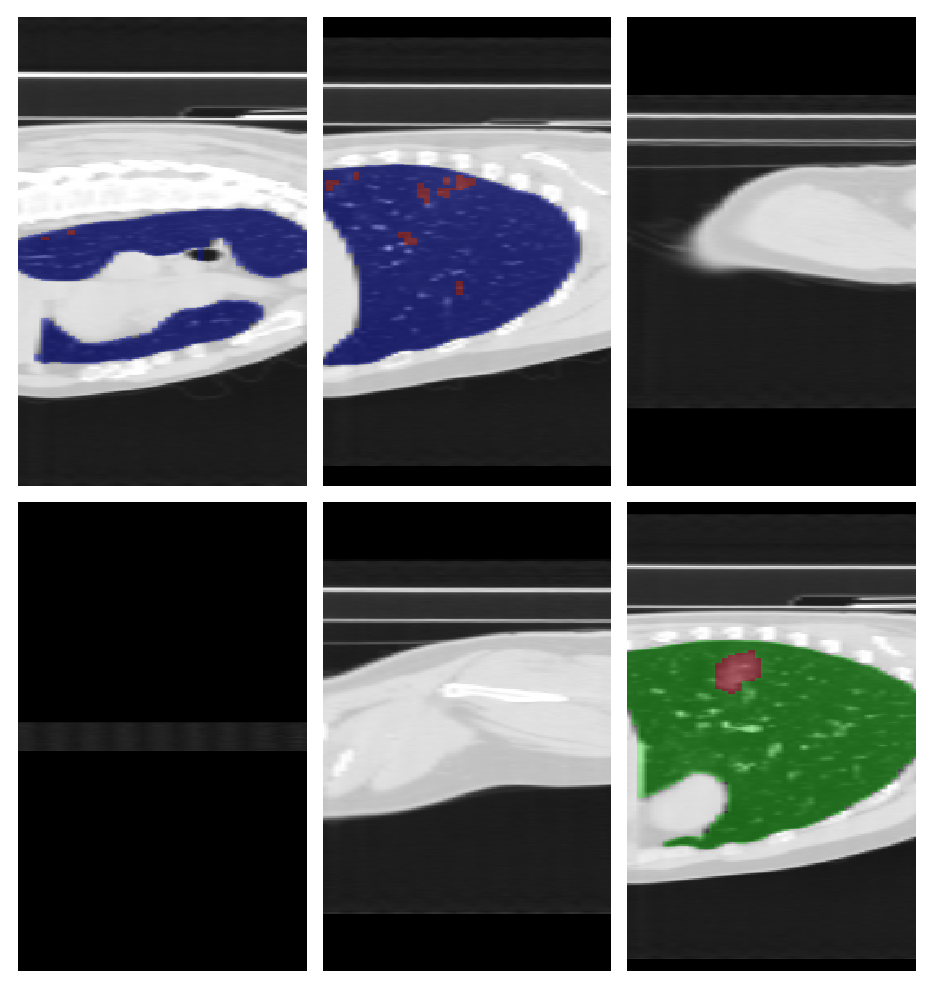

In [23]:
matshow3d(
    blended_imgs.permute(0,2,3,1),  # Intercambia los ejes 1 y 3 para cortes sagitales
    channel_dim=0,
    frame_dim=-1,
    margin=5,
    every_n=50,
    origin="lower"
)
plt.savefig("blended_imgs_sagittal.png", dpi=500)

In [24]:
import imageio
import numpy as np
import torch

# Ensure blended_imgs is available from a previous cell.
# Expected shape: (C, H, W, D), e.g., (3, 289, 289, 178) after MONAI processing.

# Permute for sagittal view. Original H becomes the slicing dimension.
# (C, H, W, D) --> (C, W, D_slice, H_slices)
# Example: (3, 289, 289, 178) --> (3, 289, 178, 289)
sagittal_volume = blended_imgs.permute(0, 2, 3, 1)

frames = []
num_sagittal_slices = sagittal_volume.shape[3]

for i in range(num_sagittal_slices):
    # Get current slice: shape (C, W_slice, D_slice)
    slice_data = sagittal_volume[:, :, :, i]
    
    # Permute slice to (W_slice, D_slice, C) for imageio
    frame = slice_data.permute(1, 2, 0)
    
    # Move to CPU and convert to NumPy array
    frame_np = frame.cpu().numpy()
    
    # Normalize to [0, 255] and convert to uint8.
    # Assumes frame_np values are in [0, 1] range after blend_images.
    # If not, additional normalization might be needed.
    frame_uint8 = (frame_np * 255).astype(np.uint8)
    
    frames.append(frame_uint8)

# Save the GIF
gif_path = "sagittal_slices.gif"
imageio.mimsave(gif_path, frames, fps=10)  # Adjust fps as needed (e.g., 10-30)

print(f"Sagittal GIF saved to {gif_path}")

Sagittal GIF saved to sagittal_slices.gif


In [25]:
print(f"Image shape before inversion: {batch_data[img_key].shape}")
print(f"Mask shape before inversion: {batch_data[label_key].shape}")

with allow_missing_keys_mode(transform):
    # Invert the transform including both image and segmentation
    data_to_invert = {
        img_key: batch_data[img_key][0],
        label_key: batch_data[label_key][0],
    }
    inverted_data = transform.inverse(data_to_invert)
    # Print the shape of the inverted image and mask tensors
    print(f"Inverted image shape: {inverted_data[img_key].shape}")
    print(f"Inverted mask shape: {inverted_data[label_key].shape}")

Image shape before inversion: torch.Size([1, 1, 288, 288, 177])
Mask shape before inversion: torch.Size([1, 1, 288, 288, 177])
Inverted image shape: torch.Size([1, 630, 630, 45])
Inverted mask shape: torch.Size([1, 630, 630, 45])


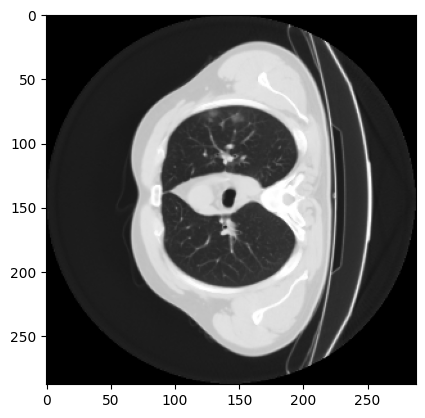

In [26]:
import matplotlib.pyplot as plt
plt.imshow(batch_data[img_key][0, 0, :, :, 123].cpu(), cmap="gray")
plt.show()

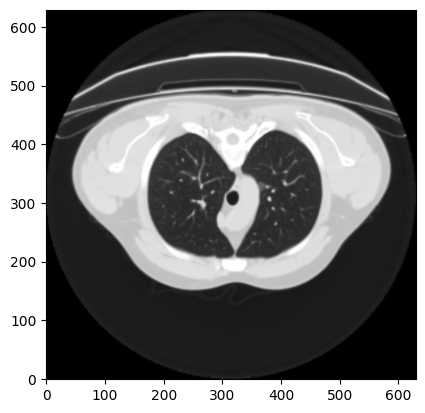

In [27]:
import matplotlib.pyplot as plt
plt.imshow(inverted_data[img_key][0, :, :, 34].transpose(0,1).cpu(), cmap="gray", origin="lower")
plt.show()

In [28]:
# Nibabel loading
vol = nib.load(data[0][img_key])
print(f"Image shape: {vol.shape}")
print(f"Image affine: {vol.affine}")
print(nib.aff2axcodes(vol.affine))
print(vol.header["pixdim"])
matrix = vol.get_fdata()

Image shape: (512, 512, 301)
Image affine: [[  -0.81054699    0.            0.          213.10714722]
 [  -0.            0.81054699    0.         -206.89215088]
 [   0.           -0.            1.         -220.05334473]
 [   0.            0.            0.            1.        ]]
('L', 'A', 'S')
[-1.        0.810547  0.810547  1.        1.        1.        1.
  1.      ]


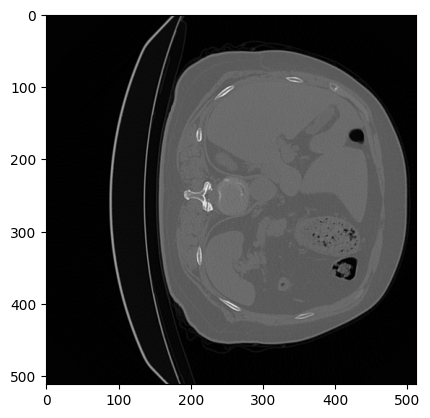

In [29]:
plt.imshow(matrix[:, :, 34], cmap="gray")
plt.show()

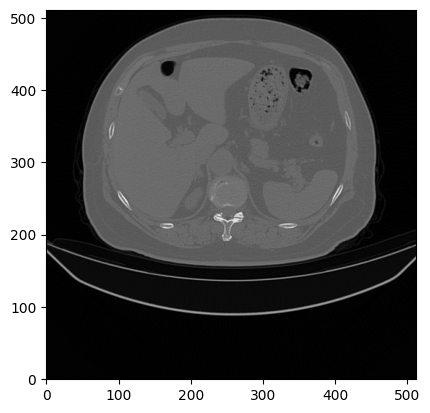

In [30]:
plt.imshow(matrix[:, :, 34].T, cmap="gray", origin="lower")
plt.show()

## Errores en los metadatos



In [31]:
result = transform(data[0])

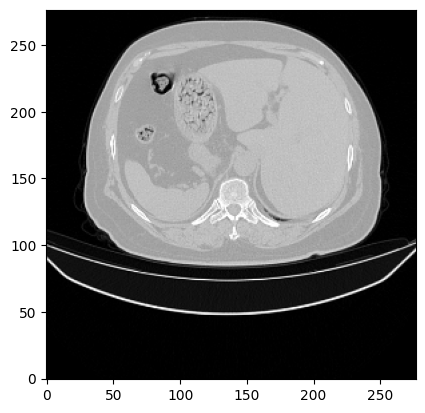

In [32]:
plt.imshow(result[img_key][0, :, :, 34].T.cpu(), cmap="gray", origin="lower")

In [33]:
img = nib.load(data[0][img_key])
print(nib.aff2axcodes(img.affine))

('L', 'A', 'S')


In [34]:
result = transform(data[19])

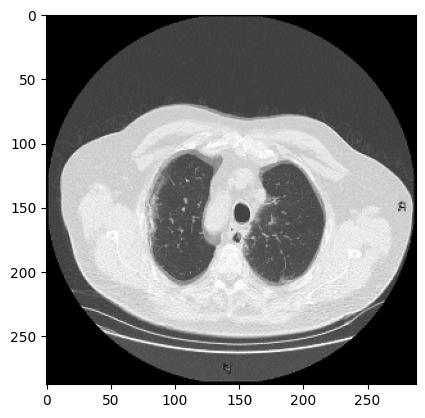

In [35]:
plt.imshow(result[img_key][0, :, :, 34].T.cpu(), cmap="gray")

In [36]:
img = nib.load(data[19][img_key])
print(nib.aff2axcodes(img.affine))

('L', 'A', 'S')


## Ejemplo de entrenamiento

In [ ]:
from monai.transforms import RandCropByPosNegLabeld
img_key = CommonKeys.IMAGE
label_key = CommonKeys.LABEL
both_keys = [img_key, label_key]


# Data setup
covid_root_dir = Path("data/")
assert covid_root_dir.exists(), f"Please download the dataset from {covid_root_dir} and unzip it."

# Define paths
raw_images_path = covid_root_dir / "COVID-19-CT-Seg_20cases"
masks_path = covid_root_dir / "Lung_Mask"
# Get file lists
raw_images = sorted(raw_images_path.glob("*corona*.nii.gz"))
masks = sorted(masks_path.glob("*corona*.nii.gz"))
assert len(raw_images) == len(masks), "Number of images and masks do not match."

data = {}
for i, (img, seg) in enumerate(zip(raw_images, masks)):
    data[i] = {
        CommonKeys.IMAGE: str(img),
        CommonKeys.LABEL: str(seg),
    }
print(f"Number of images: {len(data)}")

train_transform = Compose([
    LoadImaged(keys=both_keys, reader="NibabelReader"),
    EnsureChannelFirstd(keys=both_keys),
    ScaleIntensityRanged(
        keys=[img_key],
        a_min=-1400,
        a_max=150,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    Spacingd(
        keys=both_keys,
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
    ),
    Orientationd(
         keys=both_keys,
         axcodes=("RAS"), # Axis 0 -> R, Axis 1 -> A, Axis 2 -> S, so 0 are thre rows (Y), 1 are the columns (X), and 2 are the slices (Z)
    ),
    CropForegroundd(
        keys=both_keys,
        source_key=img_key,
        margin=10,
    ),
    RandCropByPosNegLabeld(
        keys=both_keys,
        label_key=label_key,
        spatial_size=(96,96,96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key=img_key,
    ),
    ToTensord(
        keys=both_keys,
    ),
])

train_ds = CacheDataset(
    data=data,
    transform=train_transform,
    cache_rate=0.3,
)

train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)
batch_data = first(train_loader)
print(f"Image shape: {batch_data[img_key].shape}")
print(f"Mask shape: {batch_data[label_key].shape}")

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


Number of images: 10


Loading dataset: 100%|██████████| 3/3 [00:40<00:00, 13.65s/it]


Image shape: torch.Size([4, 1, 96, 96, 96])
Mask shape: torch.Size([4, 1, 96, 96, 96])


In [49]:
print(batch_data[label_key].unique())

metatensor([0., 1., 2.])


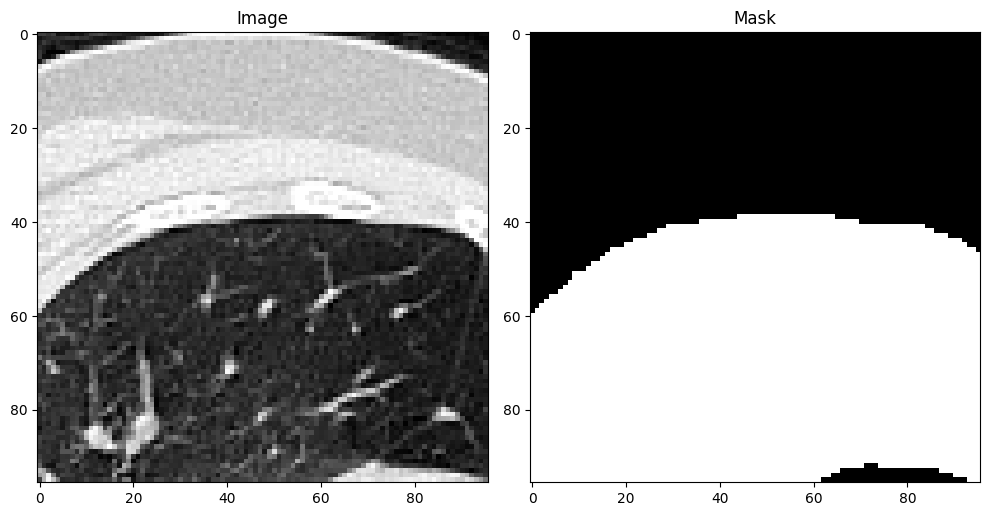

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(batch_data[img_key][0, 0, :, :, 34].cpu(), cmap="gray")
axes[0].set_title("Image")
axes[1].imshow(batch_data[label_key][0, 0, :, :, 34].cpu(), cmap="gray")
axes[1].set_title("Mask")
plt.tight_layout()
plt.show()

In [62]:
from monai.networks.nets import UNETR
from monai.losses import DiceCELoss, DiceLoss
from monai.metrics import DiceMetric
from torch.optim import AdamW
from monai.inferers import SlidingWindowInferer
import torch

model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(96,96,96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    norm_name="instance",
    res_block=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_function = DiceLoss(
    include_background=False,
    to_onehot_y=True,
    softmax=True,
)

optimizer = AdamW(model.parameters(), 1e-4, weight_decay=1e-5)


dice_metric = DiceMetric(
    include_background=False,
    reduction="mean",
    get_not_nans=False,
)

# Define the sliding window inferer
sw_inferer = SlidingWindowInferer(
    roi_size=(96, 96, 96),
    sw_batch_size=4,
    overlap=0.6,
)

scaler = torch.GradScaler("cuda")

In [ ]:
def show_voxel(img, mask, title=None):
    print("Printing voxel data.....")
    img = img.detach().cpu().numpy()
    blended = blend_images(img, mask, alpha=0.3)
    matshow3d(
        blended,
        channel_dim=0,
        frame_dim=-1,
        margin=5,
        origin="lower",
        show=True
    )
    print("Voxel data printed successfully.")

In [ ]:
num_epoch = 100
from monai.data import decollate_batch
import monai.transforms

post_pred = Compose([
    monai.transforms.AsDiscrete(argmax=True, to_onehot=3),
])


post_label = Compose([
    monai.transforms.AsDiscrete(to_onehot=3),
])

visualization = Compose([
    monai.transforms.AsDiscrete(argmax=True),
])

best_dice = 0.0
for epoch in range(num_epoch):
    print(f"Epoch {epoch + 1}/{num_epoch}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data[img_key].to(device),
            batch_data[label_key].to(device),
        )
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        preds = sw_inferer(inputs, model)
        
        post_preds_list = [post_pred(i) for i in decollate_batch(preds)]
        post_label_list = [post_label(i) for i in decollate_batch(labels)]
        dice_metric(y_pred=post_preds_list, y=post_label_list)
        # Compute the loss
        # Backpropagation
        # Use the gradient scaler for mixed precision training and saving memory
        # This is especially useful for large models
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad() # Reset the gradients
        # Update the loss
        epoch_loss += loss.item()

        
        print(f"Step {step}, Loss: {loss.item():.4f}")
    _dice = dice_metric.aggregate().item()

    if epoch % 1 == 0:
        model.eval()
        with torch.no_grad():
            output_sample = model(inputs[0].unsqueeze(0))
            output_sample = [visualization(i) for i in decollate_batch(output_sample)]
            output_sample = output_sample[0].cpu().numpy()
            show_voxel(inputs[0], output_sample, title="Sample Output")

    if _dice > best_dice:
        best_dice = _dice
        torch.save(model.state_dict(), "best_metric_model.pth")
        print(f"Saved new best metric model with Dice: {_dice:.4f}")

    print(f"Epoch {epoch + 1} average loss: {epoch_loss / step:.4f} | Dice: {_dice:.4f}")
    dice_metric.reset()

Epoch 1/100
Step 1, Loss: 0.8931
Step 2, Loss: 0.7821
Step 3, Loss: 0.8708
Step 4, Loss: 0.7427
Step 5, Loss: 0.8978
Step 6, Loss: 0.9458
Step 7, Loss: 0.8602
Step 8, Loss: 0.8675
Step 9, Loss: 0.8809
Step 10, Loss: 0.9722
Printing voxel data.....


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [61]:
import monai.transforms
import numpy as np

trans = Compose([
    monai.transforms.AsDiscrete(argmax=True),
])

trans(np.array([[[0, 1, 2], [3, 4, 5]]]))

metatensor([[[0., 0., 0.],
         [0., 0., 0.]]])

In [30]:
cbct_transform = Compose([
    LoadImaged(keys=both_keys, reader="NibabelReader"),
    EnsureChannelFirstd(keys=both_keys),
    monai.transforms.ScaleIntensityRanged(
        keys=[img_key],
        a_min=0,
        a_max=255,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    Spacingd(
        keys=both_keys,
        pixdim=(1.5, 1.5, 1.5),
        mode=("bilinear", "nearest"),
    ),
    Orientationd(
         keys=both_keys,
         axcodes=("RAS"), # Axis 0 -> R, Axis 1 -> A, Axis 2 -> S, so 0 are thre rows (Y), 1 are the columns (X), and 2 are the slices (Z)
    ),
    CropForegroundd(
        keys=both_keys,
        source_key=img_key,
        margin=10,
    ),
    LabelFilterd(
        keys=[label_key],
        applied_labels=[0,1]
    ),
    ToTensord(
        keys=both_keys,
    ),
])

test_sample = {
    img_key: "data/COVID-19-CT-Seg_20cases/radiopaedia_4_85506_1.nii.gz",
    label_key: "data/Lung_Mask/radiopaedia_4_85506_1.nii.gz",
}

test_sample = cbct_transform(test_sample)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [31]:
model = model = UNETR(
    in_channels=1,
    out_channels=1,
    img_size=(96,96,96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    norm_name="instance",
    res_block=True,
)

model.load_state_dict(torch.load("best_metric_model.pth"))
model.eval()

UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (to_q): Identity()
          (to_k): Identity()
          (to_v): Identity()
          (input_rearrange): Rearrange('b h (qkv l d) -> qkv b l h d', qkv=3,

In [ ]:
with torch.no_grad():
    pred = sw_inferer(test_sample[img_key].unsqueeze(0), model.to("cpu"), device="cpu")
pred = pred.detach().cpu()
pred = post_transform(pred)
pred = pred[0].cpu().numpy()
print(f"Pred shape: {pred.shape}")
print(f"Pred min: {pred.min()}, max: {pred.max()}")

Pred shape: (1, 288, 288, 153)


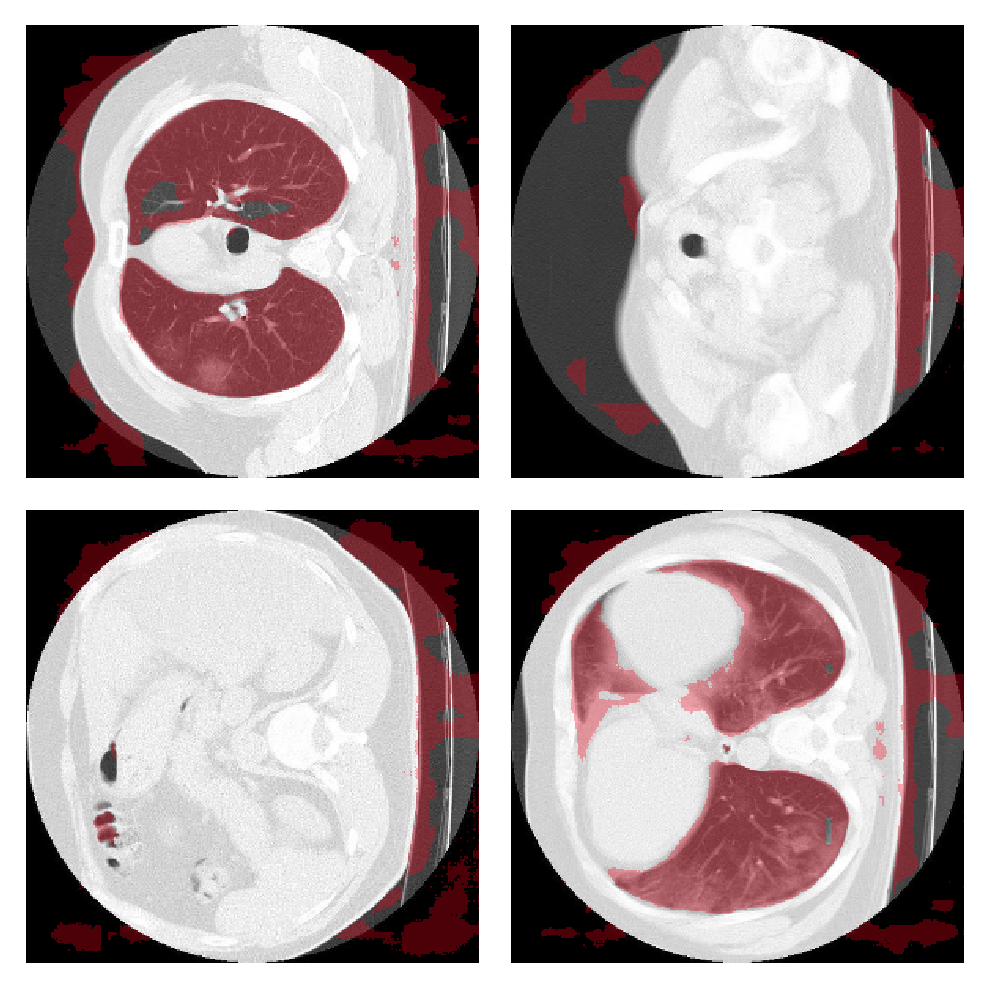

(<Figure size 1000x1000 with 1 Axes>,
 array([[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        ...,
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
    

In [34]:
blended_imgs = blend_images(
    test_sample[img_key],
    pred,
    alpha=0.3,
)

matshow3d(
    blended_imgs, # Transpose to match matplotlib's expected input
    channel_dim=0,
    frame_dim=-1,
    margin=10,
    every_n=50,
    origin="lower",
    show=True
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


Image shape: torch.Size([1, 234, 234, 201])
Pred shape: (1, 234, 234, 201)


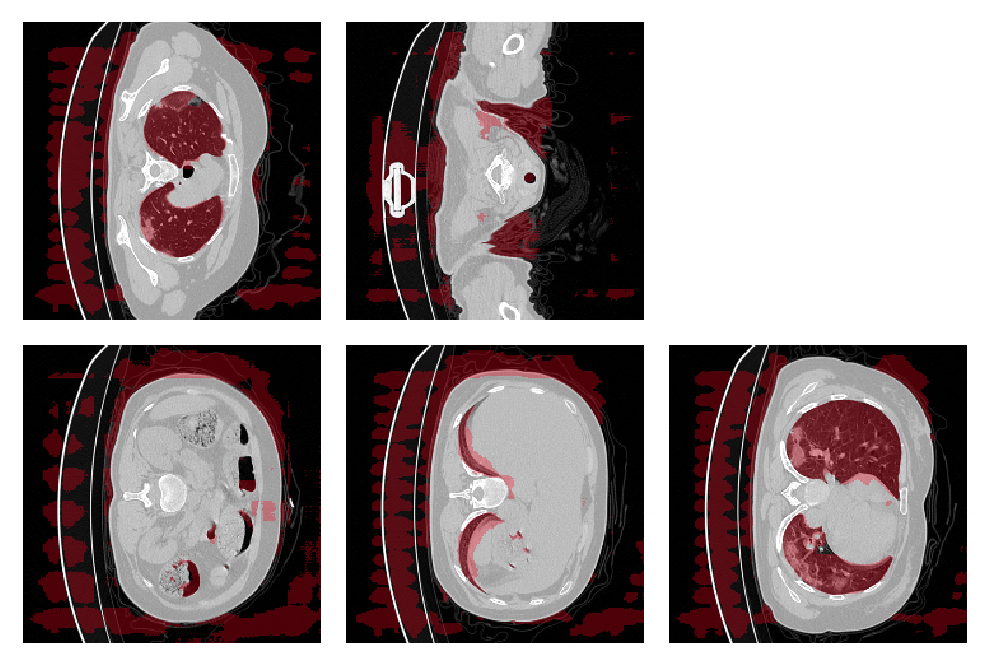

(<Figure size 1000x1000 with 1 Axes>,
 array([[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        ...,
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
    

In [36]:
ct_pipeline = Compose([
    LoadImaged(keys=[img_key], reader="NibabelReader"),
    EnsureChannelFirstd(keys=[img_key]),
    ScaleIntensityRanged(
        keys=[img_key],
        a_min=-1000,
        a_max=400,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    Spacingd(
        keys=[img_key],
        pixdim=(1.5, 1.5, 1.5),
        mode=("bilinear"),
    ),
    Orientationd(
         keys=[img_key],
         axcodes=("RAS"), # Axis 0 -> R, Axis 1 -> A, Axis 2 -> S, so 0 are thre rows (Y), 1 are the columns (X), and 2 are the slices (Z)
    ),
    CropForegroundd(
        keys=[img_key],
        source_key=img_key,
        margin=10,
    ),
    ToTensord(
        keys=[img_key],
    ),
])

train_sample = {
    img_key: "data/COVID-19-CT-Seg_20cases/coronacases_010.nii.gz",
    label_key: "data/Lung_Mask/coronacases_010.nii.gz",
}
train_sample = ct_pipeline(train_sample)
print(f"Image shape: {train_sample[img_key].shape}")

sw_inferer = SlidingWindowInferer(
    roi_size=(96, 96, 96),
    sw_batch_size=4,
    overlap=0.7,
    mode="gaussian",
)

with torch.no_grad():
    pred = sw_inferer(train_sample[img_key].unsqueeze(0), model.to("cpu"), device="cpu")
    
pred = pred.detach().cpu()
pred = post_transform(pred)
pred = pred[0].cpu().numpy()
print(f"Pred shape: {pred.shape}")

blended_imgs = blend_images(
    train_sample[img_key],
    pred,
    alpha=0.3,
)
matshow3d(
    blended_imgs, # Transpose to match matplotlib's expected input
    channel_dim=0,
    frame_dim=-1,
    margin=10,
    every_n=50,
    origin="lower",
    show=True
)